In [52]:
import requests
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import os
# для работы с дата время
from datetime import datetime
#для переворота словаря
from operator import itemgetter
import time #для циклса, чтобы сделать паузу между обращениями к api hh

In [53]:
sber = '3529'
page = 1
num_per_page = 100
#moscow = 1 убрал везде москву
url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}'

In [54]:
res = requests.get(url)
vacancies = res.json()
num_pages = vacancies.get('pages')
vacancy_ids = [el.get('id') for el in vacancies.get('items')]

In [55]:
all_vacancy_ids= []
for i in tqdm(range(vacancies.get('pages'))):
    url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={i}&per_page={num_per_page}'
    res = requests.get(url)
    vacancies = res.json()
    vacancy_ids = [el.get('id') for el in vacancies.get('items')]
    all_vacancy_ids.extend(vacancy_ids)

  0%|          | 0/20 [00:00<?, ?it/s]

In [56]:
# проверяем число вакансий
len(all_vacancy_ids)

2000

In [57]:
#достаем все по вакансиям, подробно
vacancy_all_info = []
for ii in range(6): #число вероятно можно увеличить, но для экономии времени остановился на 5 по 70 
    # Запрос исполняется 15 минут
    for i in range(0, 70): #Не реально втянуть все 2000.просит капчу после 70-й вакансии. 
        #ограничился 70 вакансиями сути решения не меняет
        vac_id = all_vacancy_ids[i]
        url = f'https://api.hh.ru/vacancies/{vac_id}'
        res = requests.get(url)
        vacancy = res.json()
        vacancy_all_info.append(vacancy)
    print(ii)
    time.sleep(180)

0
1
2
3
4
5


In [98]:
#pd.DataFrame(vacancy_all_info, columns = ['name','id','description','published_at','key_skills'])

In [60]:
#Создаем DataFrame с нужными нам полями из всего массива данных
vac_info = pd.DataFrame(vacancy_all_info, columns = ['name','id','description','published_at','key_skills'])

In [61]:
# создаем функцию для конвертации в дату столбца 'published_at'
def convert_datetime(x):
    """
    переводим строку в дату 
    """
    if type(x)==str:
        new_x = datetime.strptime(x[:10], '%Y-%m-%d')
        return new_x
    else :
        new_x = None  # не знал как обойти когда вместо строки приходит что то иное
        return new_x

In [62]:
#меняем тип данных в колонке published_at на datetime
vac_info['published_at'] = pd.to_datetime(vac_info['published_at'].apply(convert_datetime))

In [63]:
#проверем тип данных 
vac_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   name          420 non-null    object        
 1   id            420 non-null    object        
 2   description   420 non-null    object        
 3   published_at  420 non-null    datetime64[ns]
 4   key_skills    420 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 16.5+ KB


In [64]:
#группируем по полю published_at и записываем в новый DataFrame
vac_info_date_count = vac_info.groupby(['published_at']).count()
#Создаем новую таблицо только дляграфика
vac_info_date_count_plot = pd.DataFrame(vac_info_date_count, columns = ['id'])
#vac_info_date_count_plot


<AxesSubplot:xlabel='published_at'>

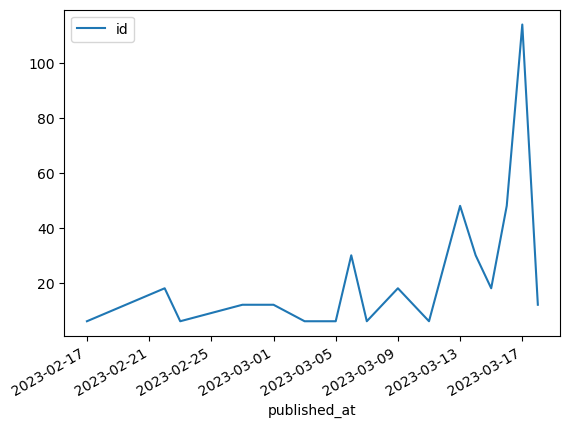

In [65]:
#строим график график опубликованных вакансий по датам
vac_info_date_count_plot.plot()

In [66]:
vac_info_day_week = pd.DataFrame(vacancy_all_info, columns = ['name','id','description','published_at','key_skills'])

In [67]:
def convert_date_week(x):
    """
    переводим дату в день недели
    """
    if type(x)==str:
        new_x = datetime.weekday(datetime.strptime(x[:10], '%Y-%m-%d'))
        #datetime.weekday 0-понедельник 6 - воскресение
        return new_x
    else :
        new_x = 6 # None  # не знал как обойти когда вместо строки приходит что то иное, поэтому воскресение
        return new_x

In [68]:
#меняем тип данных в колонке published_at на datetime и преобразуев в дни недели
vac_info_day_week['published_at'] = vac_info_day_week['published_at'].apply(convert_date_week).astype(int)

In [69]:
#группируем по полю published_at и записываем в новый DataFrame
vac_info_date_week_count = vac_info_day_week.groupby(['published_at']).count()
vac_info_date_week_count
#из таблицы видим, максимальное число вакансий в 4 день, что соотвествует пятнице

,name,id,description,key_skills
published_at,,,,
0,90,90,90,90
1,48,48,48,48
2,48,48,48,48
3,72,72,72,72
4,138,138,138,138
5,18,18,18,18
6,6,6,6,6


In [70]:
#Найдите вакансии с использованием python, которые вам интересны
vac_desc = pd.DataFrame(vacancy_all_info, columns = ['name','id','description','published_at','key_skills'])

In [71]:
#через цикл проверяем есть ли в названии вакансии слово Python

vac_py = []
for i in range(len(vac_desc)):
    if type(vac_desc['name'][i]) == str:
        if ('Python' in vac_desc['name'][i]) == True:
            vac_py.append(vac_desc['name'][i])
#print(vac_py)
print('Вакансий которые нам нравяться(со словом Python): '  + str(len(vac_py)))


Вакансий которые нам нравяться(со словом Python): 6


In [73]:
#Определите по полю с ключевыми навыками, какие навыки больше всего востребованы для найденных вакансий
vac_skill = pd.DataFrame(vacancy_all_info, columns = ['name','id','description','published_at','key_skills'])

In [74]:
#Перебираем все существующие требования к навыкам в поле key_skills и записываем их в лист
skill = []
for i in range(len(vac_skill)): 
    if len(vac_skill['key_skills'][i]) != 0: #смотрим только существующие значения
        x=vac_skill['key_skills'][i]
        for j in range(len(x)): #и так как это словарь вытаскиваем значения ключаname
            skill.append(x[j]['name'])
#skill

In [75]:
# функцию нашел в инернетах, позволяет сравнением создать иной словарь
def analysis(your_list, your_dict):
    for i in your_list:
        if i in your_dict:
            your_dict[i] += 1
        else:
            your_dict[i] = 1

In [76]:
#создаем переменную под новый словарь и применяем функцию
dct_skill = {}
analysis(skill, dct_skill)
#dct_skill

In [77]:
#Сортируем по значениям а не ключам, и разворачиваем чтобы самое большое количество получить первым
dct_skill_sort = dict(sorted(dct_skill.items(), key=itemgetter(1), reverse=True))
#dct_skill_sort

In [78]:
#находим индексы максимальных значений, вдруг оно не одно 
index_for_max = []
for i in range(len(dct_skill_sort.values())):
    if list(dct_skill_sort.values())[i] == max(list(dct_skill_sort.values())):
        index_for_max.append(i)
    
#print(index_for_max)
    

In [79]:
# Выводим ключи максимальных значений
print('Самые востребованные навыки: ')
for i in index_for_max:
    print(list(dct_skill_sort.keys())[i])

Самые востребованные навыки: 
Деловое общение


In [ ]:
#Постройте график наиболее востребованных навыков
# берем список который получили ранее dct_skill

In [81]:
#Нагуглил круговую диаграмму и только через нее смог сделать:
import plotly as py
import plotly.graph_objs as go
pyplt=py.offline.plot
labels=list(dct_skill.keys())[0:len(list(dct_skill.keys()))]
values=list(dct_skill.values())[0:len(list(dct_skill.values()))]
trace=[go.Pie(labels=labels,values=values)]
layout=go.Layout(
    title='График процентов наиболее востребованных навыков'
)
fig=go.Figure(data=trace,layout=layout)
fig.show()